###

In [12]:
## 1. Importing Libraries

import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from IPython.display import Audio
import seaborn as sns


In [2]:
## 2. Paths & Classes

DATA_DIR = os.path.join('..', 'data', 'audio')
CLASSES = ['blues','classical','country','disco','hiphop',
           'jazz','metal','pop','reggae','rock']


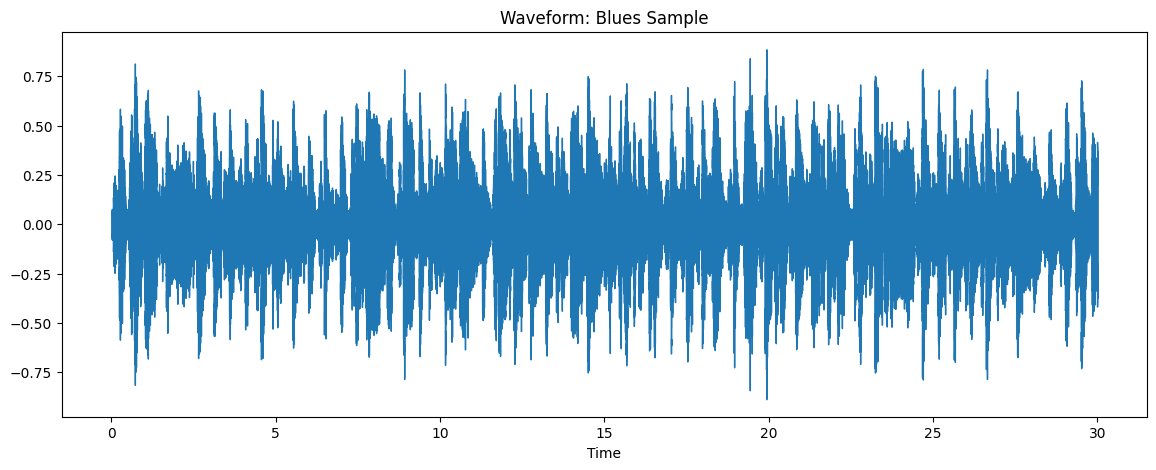

In [3]:
## 3. Visualizing a Single Audio File

random_file = os.path.join(DATA_DIR, 'blues', 'blues.00000.wav')
y, sr = librosa.load(random_file, sr=44100)
plt.figure(figsize=(14,5))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform: Blues Sample")
plt.show()

Audio(data=y, rate=sr)


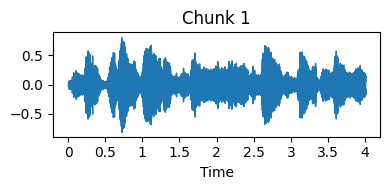

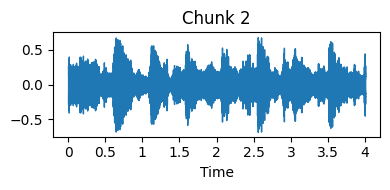

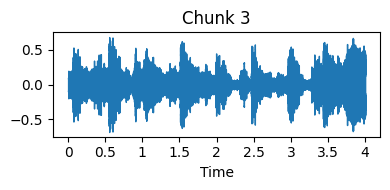

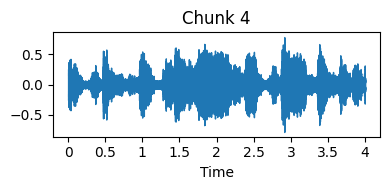

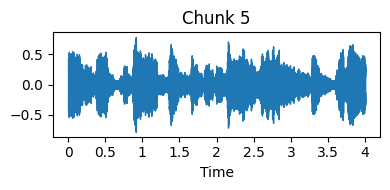

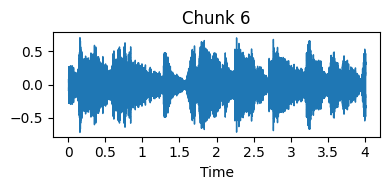

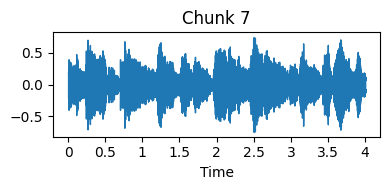

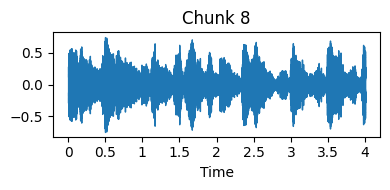

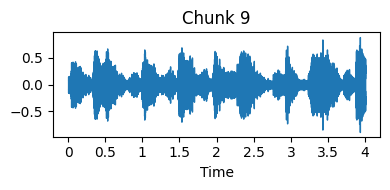

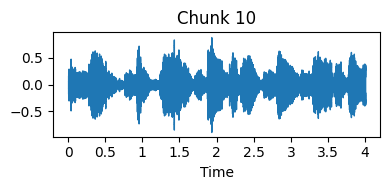

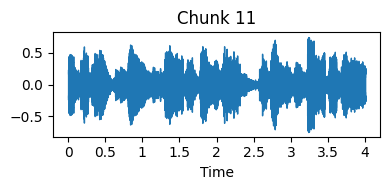

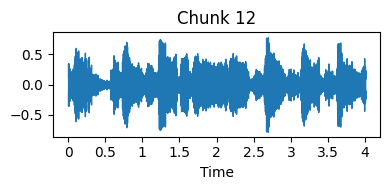

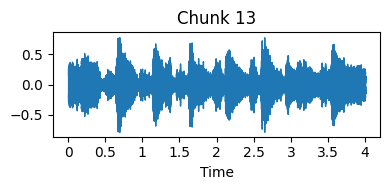

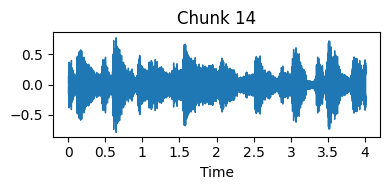

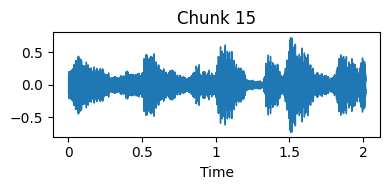

In [4]:
## 4. Chunk-wise Waveform Visualization

chunk_dur, overlap_dur = 4, 2  # in seconds
chunk_samp, overlap_samp = chunk_dur*sr, overlap_dur*sr
num_chunks = int(np.ceil((len(y)-chunk_samp)/(chunk_samp-overlap_samp))) + 1

for i in range(num_chunks):
    start = i*(chunk_samp-overlap_samp)
    end = start + chunk_samp
    chunk = y[start:end]
    plt.figure(figsize=(4,2))
    librosa.display.waveshow(chunk, sr=sr)
    plt.title(f"Chunk {i+1}")
    plt.tight_layout()
    plt.show()



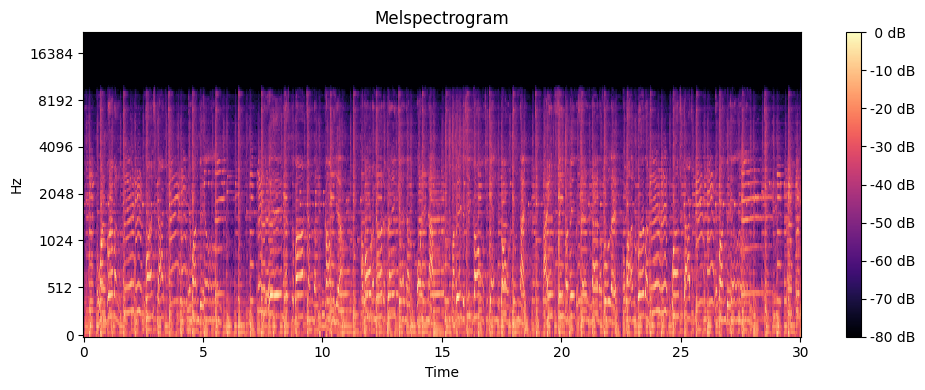

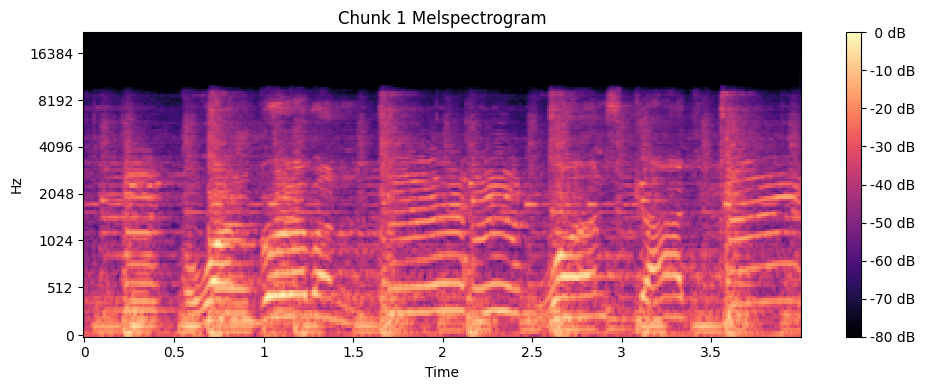

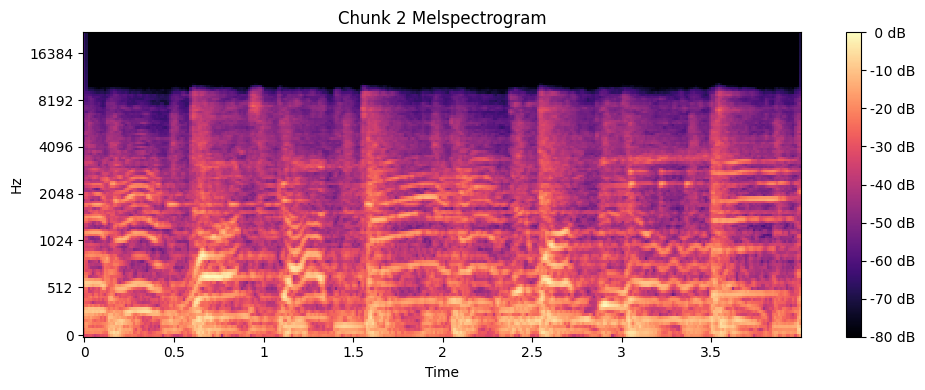

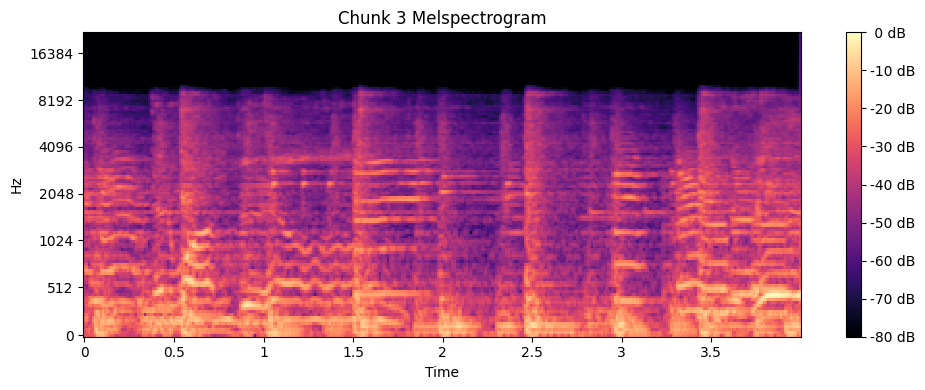

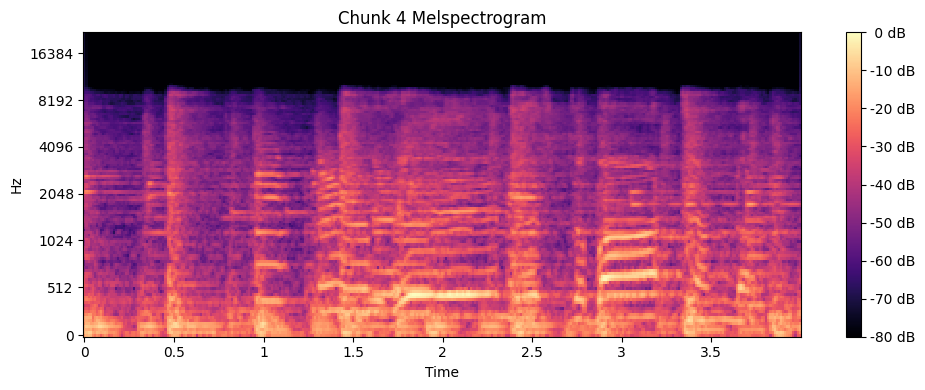

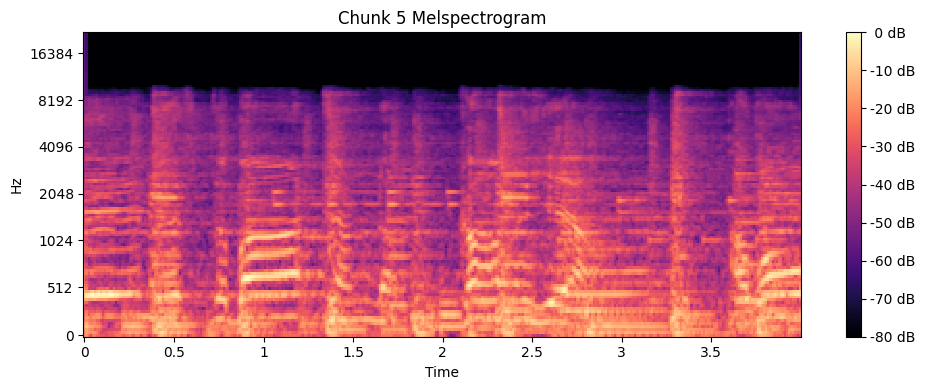

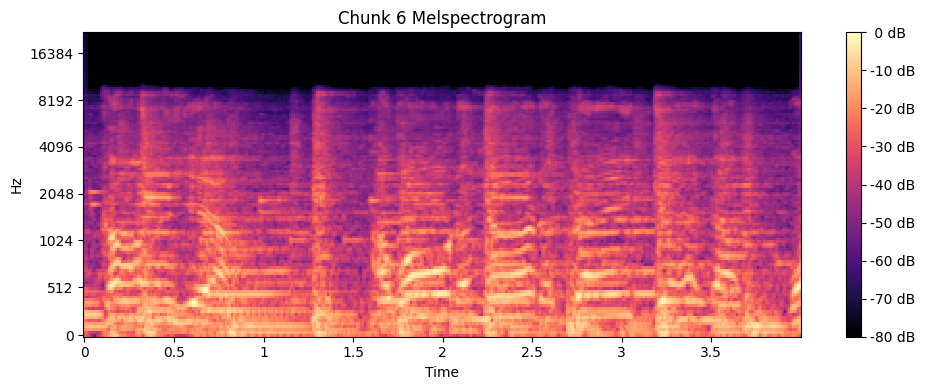

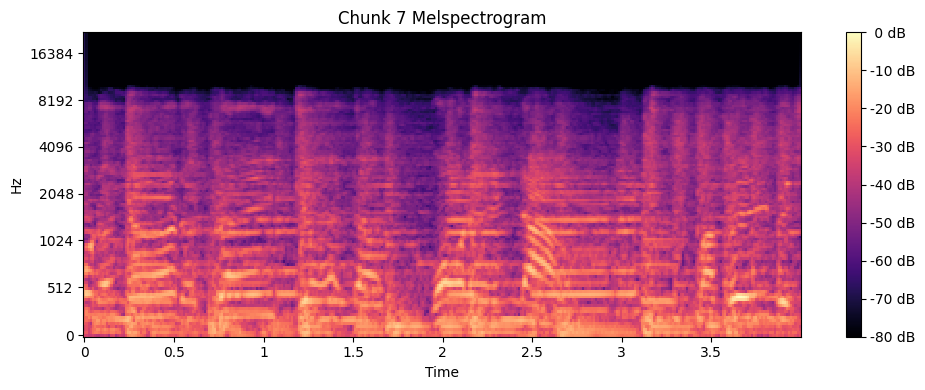

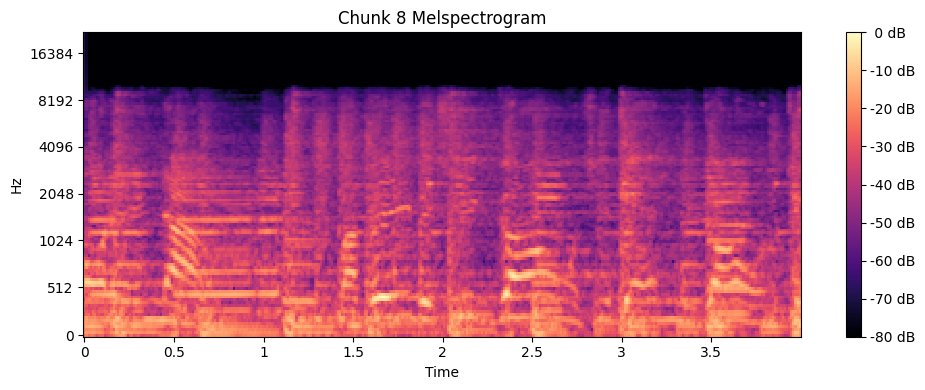

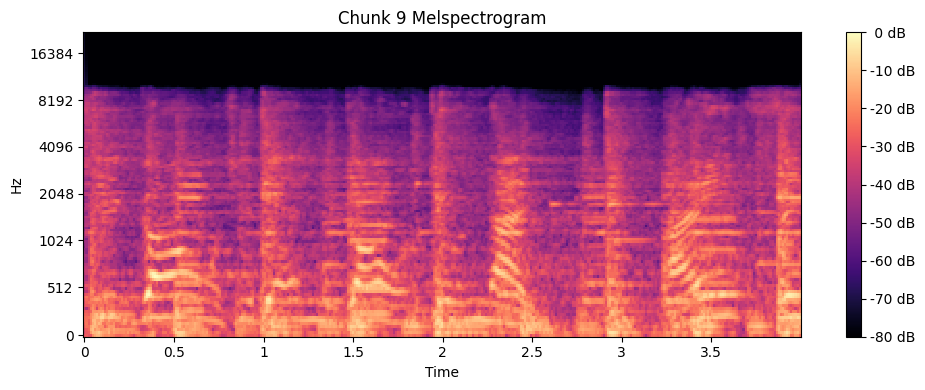

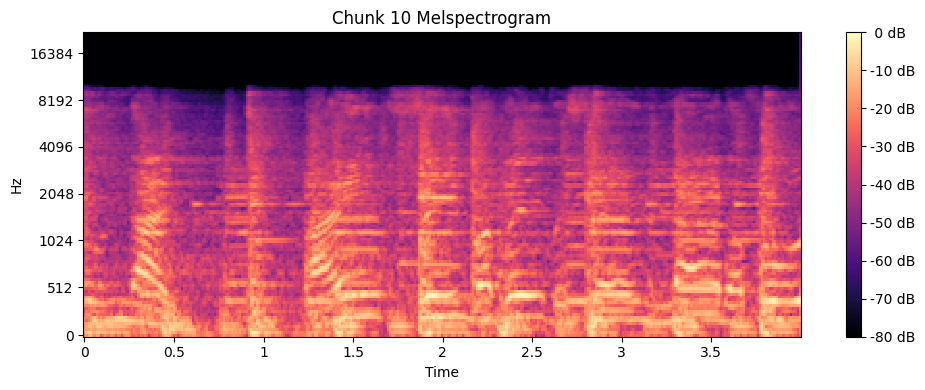

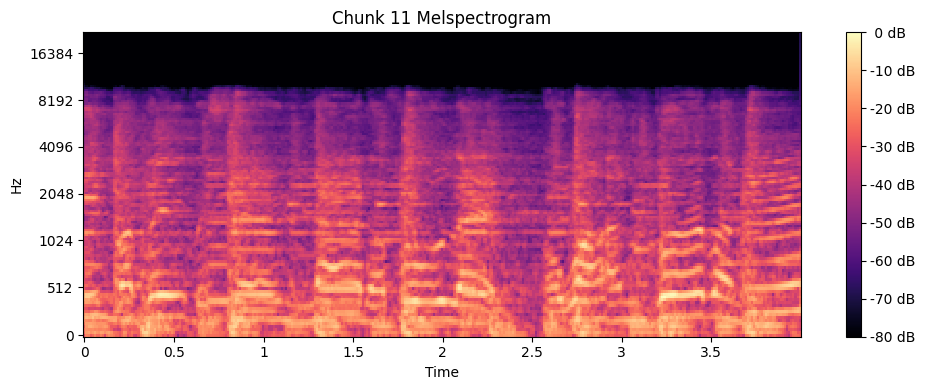

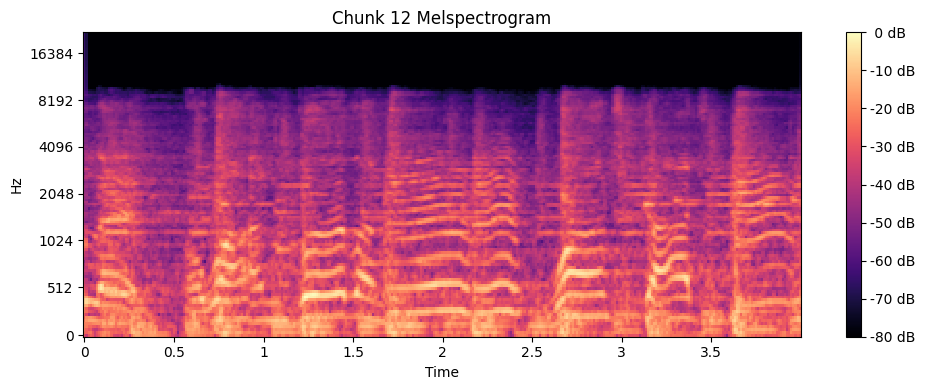

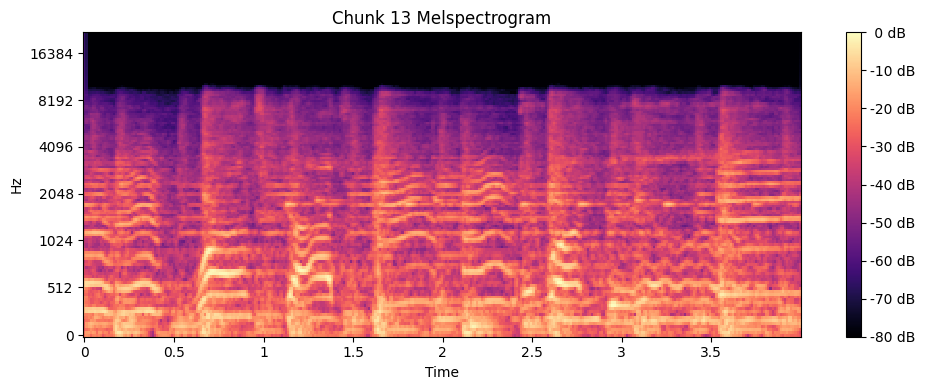

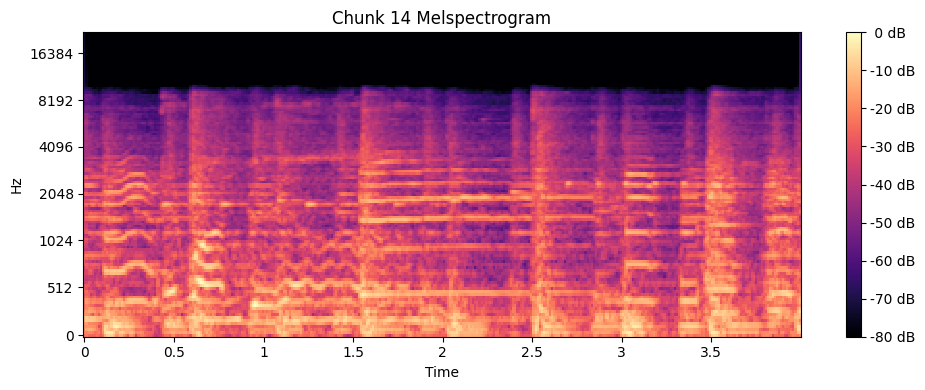

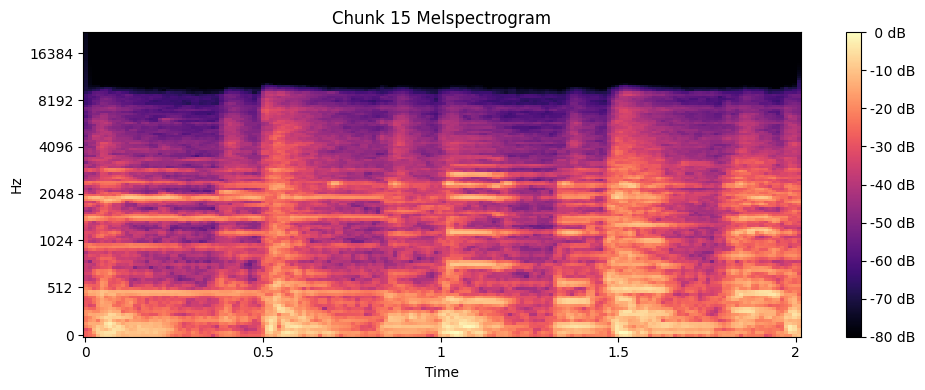

In [5]:
## 5. Melspectrogram Functions

def plot_melspectrogram(y, sr):
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%2.0f dB')
    plt.title("Melspectrogram")
    plt.tight_layout()
    plt.show()

plot_melspectrogram(y, sr)

def plot_melspec_chunks(y, sr, chunk_dur=4, overlap_dur=2):
    c_s, o_s = chunk_dur*sr, overlap_dur*sr
    n = int(np.ceil((len(y)-c_s)/(c_s-o_s))) + 1
    for i in range(n):
        start = i*(c_s-o_s); end = start + c_s
        chunk = y[start:end]
        S = librosa.feature.melspectrogram(y=chunk, sr=sr)
        S_db = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(10,4))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title(f"Chunk {i+1} Melspectrogram")
        plt.tight_layout()
        plt.show()

plot_melspec_chunks(y, sr)



In [9]:
## 6. Data Preprocessing

def load_and_preprocess_data(data_dir, classes, target_shape=(150,150)):
    data, labels = [], []

    for idx, genre in enumerate(classes):
        genre_dir = os.path.join(data_dir, genre)
        print("Processing", genre)

        for fname in os.listdir(genre_dir):
            # only WAV files (case-insensitive)
            if not fname.lower().endswith('.wav'):
                continue

            fpath = os.path.join(genre_dir, fname)
            try:
                audio, sr = librosa.load(fpath, sr=None)
            except Exception as e:
                print(f"  ⚠️  Skipping {fpath}: {e}")
                continue

            # chunking parameters
            chunk_dur, overlap_dur = 4, 2
            chunk_samp, overlap_samp = chunk_dur * sr, overlap_dur * sr
            n_chunks = int(np.ceil((len(audio) - chunk_samp) /
                                   (chunk_samp - overlap_samp))) + 1

            for i in range(n_chunks):
                start = i * (chunk_samp - overlap_samp)
                end   = start + chunk_samp
                chunk = audio[start:end]

                # mel → resize
                mel = librosa.feature.melspectrogram(y=chunk, sr=sr)
                mel = resize(np.expand_dims(mel, -1), target_shape)

                data.append(mel)
                labels.append(idx)

    X = np.array(data, dtype=np.float32)
    y = tf.keras.utils.to_categorical(labels, num_classes=len(classes))
    return X, y

# load everything
data, labels = load_and_preprocess_data(DATA_DIR, CLASSES)
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)




Processing blues
Processing classical
Processing country
Processing disco
Processing hiphop
Processing jazz
Processing metal
Processing pop
Processing reggae
Processing rock
Data shape: (14990, 150, 150, 1)
Labels shape: (14990, 10)


In [10]:
## 7. Train/Test Split

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

In [13]:
## 8. Model Building

model = tf.keras.models.Sequential([
    Conv2D(32,3,padding='same',activation='relu', input_shape=X_train[0].shape),
    Conv2D(32,3,activation='relu'),
    MaxPool2D(2,2),

    Conv2D(64,3,padding='same',activation='relu'),
    Conv2D(64,3,activation='relu'),
    MaxPool2D(2,2),

    Conv2D(128,3,padding='same',activation='relu'),
    Conv2D(128,3,activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.3),

    Conv2D(256,3,padding='same',activation='relu'),
    Conv2D(256,3,activation='relu'),
    MaxPool2D(2,2),

    Conv2D(512,3,padding='same',activation='relu'),
    Conv2D(512,3,activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.3),

    Flatten(),
    Dense(1200, activation='relu'),
    Dropout(0.45),
    Dense(len(CLASSES), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
## 9. Training

history = model.fit(
    X_train, Y_train,
    epochs=30, batch_size=32,
    validation_data=(X_test, Y_test)
)

model.save(os.path.join('..','models','Trained_model.h5'))



Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - accuracy: 0.1882 - loss: 2.1852 - val_accuracy: 0.4096 - val_loss: 1.6164
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.4393 - loss: 1.5683 - val_accuracy: 0.5904 - val_loss: 1.1869
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.5771 - loss: 1.1872 - val_accuracy: 0.6568 - val_loss: 0.9753
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 374s 996ms/step - accuracy: 0.6482 - loss: 1.0098 - val_accuracy: 0.6671 - val_loss: 0.9940
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 373s 993ms/step - accuracy: 0.7076 - loss: 0.8639 - val_accuracy: 0.7412 - val_loss: 0.7758
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 371s 988ms/step - accuracy: 0.7572 - loss: 0.7218 - val_accuracy: 0.7612 - val_loss: 0.7258
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.7848 - loss: 0.6481 - val_accuracy: 0.7825 - val_loss: 0.6597
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 375s 999ms/step - accuracy: 0.8221 - loss: 0.525